RNN构建

In [21]:
import pandas as pd
import numpy as np
import datetime 
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
import matplotlib.pyplot as plt

数据集构建：前n天数据作为参数，当天数据作为label

In [22]:
#数据导入
series=pd.read_csv(
    filepath_or_buffer='C:/Users/zhouteng/DL_pytorch/data/AU08-20.csv',
    sep=',', # 数据分割符，csv默认为“，”，此处可不加，其他格式多为'\t'
    skiprows=1,  # 跳过文件第1行不读入
    nrows=20,   # 只读取前n行
    parse_dates=['Date'],  # 将指定的某几列数据识别为日期格式，不指定则默认以字符串方式读入
    index_col=['Date'],  # 将指定列设为index,否则默认为0开始的序列
    # usecols=['candle_begin_time','open'],  # 指定读取某几列数据
    # error_bad_lines=False, # 当某行数据读入有问题时，跳过该行，数据脏乱时使用
    # na_values='NULL', # 将数据中的null识别为空值，否则将识别为字符串‘null’
)
print(series)

           pre_close    open    high     low   close
Date                                                
2008-01-09    #NAME?  230.95  230.99  221.88  223.30
2008-01-10     223.3  222.50  222.85  213.70  215.12
2008-01-11    215.12  218.00  219.23  215.50  218.10
2008-01-14     218.1  218.85  220.25  217.60  220.10
2008-01-15     220.1  220.70  224.60  220.30  223.80
2008-01-16     223.8  220.60  220.60  215.40  215.89
2008-01-17    215.89  214.03  216.80  213.50  216.47
2008-01-18    216.47  214.00  214.90  212.42  214.70
2008-01-21     214.7  214.70  216.33  213.80  214.20
2008-01-22     214.2  208.00  209.50  204.72  206.42
2008-01-23    206.42  212.00  214.25  210.90  212.51
2008-01-24    212.51  213.02  217.08  212.61  216.70
2008-01-25     216.7  220.10  221.40  218.32  219.80
2008-01-28     219.8  219.60  221.97  219.20  220.33
2008-01-29    220.33  223.60  224.30  222.56  222.56
2008-01-30    222.56  221.00  222.05  220.01  220.10
2008-01-31     220.1  220.00  221.04  218.22  

In [23]:
#取每日收盘价
series_close=series['close']
print(series_close)

Date
2008-01-09    223.30
2008-01-10    215.12
2008-01-11    218.10
2008-01-14    220.10
2008-01-15    223.80
2008-01-16    215.89
2008-01-17    216.47
2008-01-18    214.70
2008-01-21    214.20
2008-01-22    206.42
2008-01-23    212.51
2008-01-24    216.70
2008-01-25    219.80
2008-01-28    220.33
2008-01-29    222.56
2008-01-30    220.10
2008-01-31    219.35
2008-02-01    218.75
2008-02-04    215.60
2008-02-05    215.26
Name: close, dtype: float64


In [24]:
df = pd.DataFrame()
n=5
for i in range(n):
    df['c%d' % i] = series_close.tolist()[i:-(n - i)]
df['y'] = series_close.tolist()[n:]
print(df)

        c0      c1      c2      c3      c4       y
0   223.30  215.12  218.10  220.10  223.80  215.89
1   215.12  218.10  220.10  223.80  215.89  216.47
2   218.10  220.10  223.80  215.89  216.47  214.70
3   220.10  223.80  215.89  216.47  214.70  214.20
4   223.80  215.89  216.47  214.70  214.20  206.42
5   215.89  216.47  214.70  214.20  206.42  212.51
6   216.47  214.70  214.20  206.42  212.51  216.70
7   214.70  214.20  206.42  212.51  216.70  219.80
8   214.20  206.42  212.51  216.70  219.80  220.33
9   206.42  212.51  216.70  219.80  220.33  222.56
10  212.51  216.70  219.80  220.33  222.56  220.10
11  216.70  219.80  220.33  222.56  220.10  219.35
12  219.80  220.33  222.56  220.10  219.35  218.75
13  220.33  222.56  220.10  219.35  218.75  215.60
14  222.56  220.10  219.35  218.75  215.60  215.26


In [25]:
#数据导入
df_main=pd.read_csv(
    filepath_or_buffer='C:/Users/zhouteng/DL_pytorch/data/AUSHFE.csv',
    sep=',', # 数据分割符，csv默认为“，”，此处可不加，其他格式多为'\t'
    skiprows=1,  # 跳过文件第1行不读入
#     nrows=20,   # 只读取前n行
    parse_dates=['Date'],  # 将指定的某几列数据识别为日期格式，不指定则默认以字符串方式读入
    index_col=['Date'],  # 将指定列设为index,否则默认为0开始的序列
    # usecols=['candle_begin_time','open'],  # 指定读取某几列数据
    # error_bad_lines=False, # 当某行数据读入有问题时，跳过该行，数据脏乱时使用
    # na_values='NULL', # 将数据中的null识别为空值，否则将识别为字符串‘null’
)
print(df_main)

           pre_close    open    high     low   close
Date                                                
2008-01-09    #NAME?  230.95  230.99  221.88  223.30
2008-01-10     223.3  222.50  222.85  213.70  215.12
2008-01-11    215.12  218.00  219.23  215.50  218.10
2008-01-14     218.1  218.85  220.25  217.60  220.10
2008-01-15     220.1  220.70  224.60  220.30  223.80
...              ...     ...     ...     ...     ...
2020-12-29    395.78  394.40  398.44  393.38  393.86
2020-12-30    393.86  394.16  395.28  392.14  393.70
2020-12-31     393.7  393.40  397.68  392.64  394.98
2021-01-04    394.98  398.98  400.80  398.90  400.04
2021-01-05    400.04     NaN     NaN     NaN  400.04

[3161 rows x 5 columns]


<Figure size 432x288 with 0 Axes>

D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 40644 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20027 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32

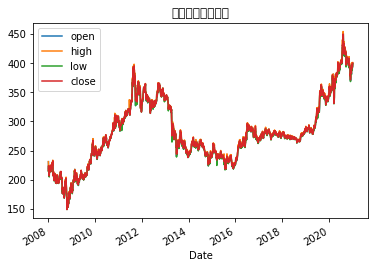

In [26]:
plt.figure()
df_main['2008':'2021'].plot()
plt.title('黄金主力合约表现')
plt.show()

D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 40644 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20027 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21147 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Users\zhouteng\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32

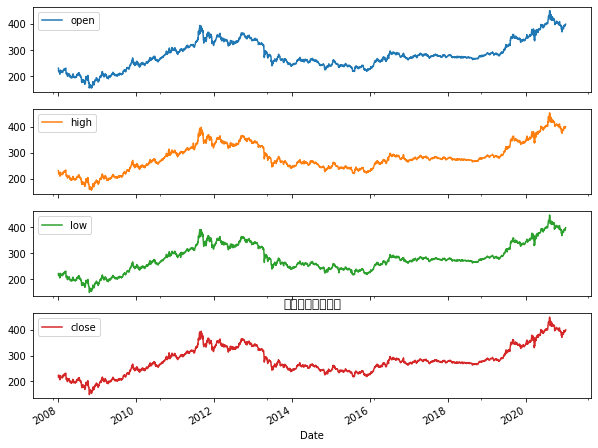

In [27]:
df_main['2008':'2021'].plot(subplots=True,figsize=(10,8))  #figsize（宽*高）
plt.title('黄金主力合约表现')
plt.show()

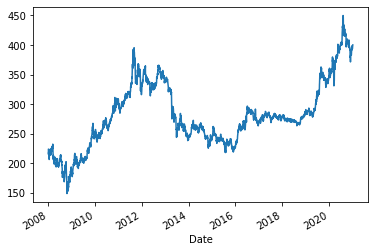

In [28]:
df_main['close'].plot()
plt.show()

In [29]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

进行minmaxscaler，防止在之后的训练过程中不收敛：

In [30]:
df_main = df_main.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
list_col=['open','high','low','close']
for col in list_col:
    df_main[col] = scaler.fit_transform(df_main[col].values.reshape(-1,1)) #归一化到-1至1范围内
print(df_main)
df_main=df_main[['open','high','low','close']].copy()

           pre_close      open      high       low     close
Date                                                        
2008-01-09    #NAME? -0.486651 -0.493390 -0.511854 -0.505352
2008-01-10     223.3 -0.543765 -0.547880 -0.566561 -0.559737
2008-01-11    215.12 -0.574180 -0.572112 -0.554523 -0.539924
2008-01-14     218.1 -0.568435 -0.565284 -0.540478 -0.526627
2008-01-15     220.1 -0.555931 -0.536165 -0.522421 -0.502028
...              ...       ...       ...       ...       ...
2020-12-29    395.78  0.618114  0.627540  0.635111  0.628615
2020-12-30    393.86  0.616492  0.606386  0.626818  0.627551
2020-12-31     393.7  0.611355  0.622452  0.630162  0.636061
2021-01-04    394.98  0.649071  0.643338  0.672028  0.669703
2021-01-05    400.04  0.649071  0.643338  0.672028  0.669703

[3161 rows x 5 columns]


In [31]:
print(df_main)

                open      high       low     close
Date                                              
2008-01-09 -0.486651 -0.493390 -0.511854 -0.505352
2008-01-10 -0.543765 -0.547880 -0.566561 -0.559737
2008-01-11 -0.574180 -0.572112 -0.554523 -0.539924
2008-01-14 -0.568435 -0.565284 -0.540478 -0.526627
2008-01-15 -0.555931 -0.536165 -0.522421 -0.502028
...              ...       ...       ...       ...
2020-12-29  0.618114  0.627540  0.635111  0.628615
2020-12-30  0.616492  0.606386  0.626818  0.627551
2020-12-31  0.611355  0.622452  0.630162  0.636061
2021-01-04  0.649071  0.643338  0.672028  0.669703
2021-01-05  0.649071  0.643338  0.672028  0.669703

[3161 rows x 4 columns]


预测下一个时间的收盘价，所以把close向上shift1个单位：

In [33]:
df_main['target'] = df_main['close'].shift(-1) 
df_main.dropna() #缺失值过滤
df_main = df_main.astype(np.float32)
print(df_main)

                open      high       low     close    target
Date                                                        
2008-01-09 -0.486651 -0.493390 -0.511854 -0.505352 -0.559737
2008-01-10 -0.543765 -0.547880 -0.566561 -0.559737 -0.539924
2008-01-11 -0.574180 -0.572112 -0.554523 -0.539924 -0.526627
2008-01-14 -0.568435 -0.565284 -0.540478 -0.526627 -0.502028
2008-01-15 -0.555931 -0.536165 -0.522421 -0.502028 -0.554617
...              ...       ...       ...       ...       ...
2020-12-29  0.618114  0.627540  0.635111  0.628615  0.627551
2020-12-30  0.616492  0.606386  0.626818  0.627551  0.636061
2020-12-31  0.611355  0.622452  0.630162  0.636061  0.669703
2021-01-04  0.649071  0.643338  0.672028  0.669703  0.669703
2021-01-05  0.649071  0.643338  0.672028  0.669703       NaN

[3161 rows x 5 columns]


根据LSTM需要的数据格式来创造数据集。Lstm需要的输入是一个3D array[x,y,z],其中x是样本数，y是seq length，即需要看多少天的数据，z是特征数。

In [34]:
def create_seq_data(data_raw,seq):
    data_feat,data_target = [],[]
    for index in range(len(data_raw) - seq):
        # 构建特征集
        data_feat.append(data_raw[['open', 'high', 'low', 'close']][index: index + seq].values)
        # 构建target集
        data_target.append(data_raw['target'][index:index + seq])
    data_feat = np.array(data_feat)
    data_target = np.array(data_target)
    return data_feat,data_target

In [35]:
create_seq_data(df_main,10)

(array([[[-0.48665088, -0.49338958, -0.51185423, -0.505352  ],
         [-0.54376477, -0.54787964, -0.5665608 , -0.5597367 ],
         [-0.5741805 , -0.5721123 , -0.55452263, -0.5399242 ],
         ...,
         [-0.6012166 , -0.6010978 , -0.5751212 , -0.5625291 ],
         [-0.5964853 , -0.59152526, -0.565892  , -0.56585336],
         [-0.64177084, -0.637246  , -0.6266176 , -0.6175786 ]],
 
        [[-0.54376477, -0.54787964, -0.5665608 , -0.5597367 ],
         [-0.5741805 , -0.5721123 , -0.55452263, -0.5399242 ],
         [-0.5684353 , -0.5652843 , -0.54047817, -0.52662724],
         ...,
         [-0.5964853 , -0.59152526, -0.565892  , -0.56585336],
         [-0.64177084, -0.637246  , -0.6266176 , -0.6175786 ],
         [-0.6147347 , -0.605449  , -0.58528674, -0.5770893 ]],
 
        [[-0.5741805 , -0.5721123 , -0.55452263, -0.5399242 ],
         [-0.5684353 , -0.5652843 , -0.54047817, -0.52662724],
         [-0.55593103, -0.53616494, -0.522421  , -0.5020278 ],
         ...,
       

设定的每个时间区间是20天，通过高开低收4个来预测，所以datafeat的维度是(3161,20,4)，对应的data_target的维度是
(3161,20,1)，1808和20和feat一样，但是因为预测只有一个数值即下一天的收盘价，所以维度为1.

然后开始划分训练和测试集划分比例：8：2

In [36]:
def train_test(data_feat,data_target,test_set_size,seq):
    train_size = data_feat.shape[0] - (test_set_size) 
    trainX = torch.from_numpy(data_feat[:train_size].reshape(-1,seq,4)).type(torch.Tensor)
    testX  = torch.from_numpy(data_feat[train_size:].reshape(-1,seq,4)).type(torch.Tensor)
    trainY = torch.from_numpy(data_target[:train_size].reshape(-1,seq,1)).type(torch.Tensor)
    testY  = torch.from_numpy(data_target[train_size:].reshape(-1,seq,1)).type(torch.Tensor)
    return trainX,trainY,testX,testY

seq = 20
data_raw=df_main
test_set_size = int(np.round(0.2*data_raw.shape[0]))
# generate train & test dataset
feat,target = create_seq_data(data_raw,seq)
trainX,trainY,testX,testY = train_test(feat,target,test_set_size,seq)

In [37]:
print('x_train.shape = ',trainX.shape)
print('y_train.shape = ',trainY.shape)
print('x_test.shape = ',testX.shape)
print('y_test.shape = ',testY.shape)

x_train.shape =  torch.Size([2509, 20, 4])
y_train.shape =  torch.Size([2509, 20, 1])
x_test.shape =  torch.Size([632, 20, 4])
y_test.shape =  torch.Size([632, 20, 1])


转化为pyorch接收格式

通过dataloader来读取数据，其中batch_size要等于训练样本数，epoch设置为100

In [38]:
n_steps = seq
batch_size = 3161
num_epochs = 100
#包装为pytorch接收的数据集
train = torch.utils.data.TensorDataset(trainX,trainY)
test = torch.utils.data.TensorDataset(testX,testY)
#加载训练集
train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)
#加载测试集
test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

构建LSTM

LSTM的参数主要有input_dim,hidden_dim,num_layers,output_dim.

其中input_dim可以看成是输入的特征数,此处为4；hidden_dim设置为32，num_layers是有几层的lstm层，output_dim是最后输出几维，由于最后我们的target只是一维所以output_dim=1.

In [39]:
#参数设置
input_dim = 4
hidden_dim = 32
num_layers = 2 
output_dim = 1

#LSTM
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    #前向传播
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out) 
        return out   

In [40]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
print(model)

LSTM(
  (lstm): LSTM(4, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


定义损失函数和优化器，损失函数使用MSE，优化器使用ADAM

In [41]:
loss_fn = torch.nn.MSELoss(size_average=True)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

D:\Users\zhouteng\anaconda3\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


模型训练

初始化h和c状态 -> 前向传播 -> 计算loss -> 计算梯度 -> 后向更新权重 -> 优化权重参数。

In [42]:
hist = np.zeros(num_epochs)
seq_dim = seq
for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(trainX)

    loss = loss_fn(y_train_pred, trainY)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.021140137687325478
Epoch  20 MSE:  0.009971095249056816
Epoch  30 MSE:  0.0052365753799676895
Epoch  40 MSE:  0.002971199806779623
Epoch  50 MSE:  0.002082136459648609
Epoch  60 MSE:  0.001437039696611464
Epoch  70 MSE:  0.0010533746099099517
Epoch  80 MSE:  0.0008163535967469215
Epoch  90 MSE:  0.0006770738982595503


预测过程

因为我们所拿到的最后的预测结果其实还是（num_sample，20,1）这样一个状态，但我们想要的是每个sample只要最后一个时期的预测，所以我们就只拿每个sample的20天的预测结结果的最后一天的进行和真实的target比较就好,即下面的y_test_pred.detach().numpy()[:,-1,0]；

In [43]:
y_test_pred = model(testX)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy()[:,-1,0].reshape(-1,1))
y_train = scaler.inverse_transform(trainY.detach().numpy()[:,-1,0].reshape(-1,1))
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy()[:,-1,0].reshape(-1,1))
y_test = scaler.inverse_transform(testY.detach().numpy()[:,-1,0].reshape(-1,1))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, y_test_pred))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.20 RMSE
Test Score: 5.58 RMSE


In [53]:
print(y_test_pred.shape)

(632, 1)


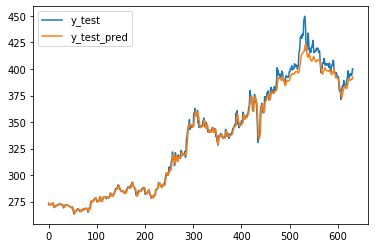

In [63]:
x=pd.date_range('2018-5-4','2021-1-5',freq='1d') #横坐标日期范围及间隔
plt.plot(y_test,label='y_test')
plt.plot(y_test_pred,label='y_test_pred')
plt.legend(['y_test','y_test_pred']) #显示图例
plt.savefig('y_test.png')
plt.show()

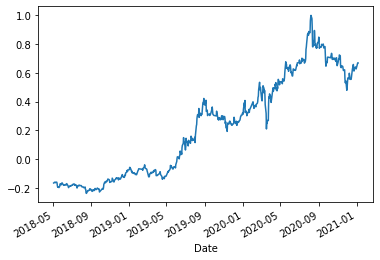

In [64]:
df_main.loc['2018-05-04':'2021-01-05','close'].plot()
plt.savefig('close_test.png')